# Accessing stellar spectra

In the previous notebook we saw how to configure our *DataClass* to open ESPRESSO observations. In this, we will see how we can interact with the stellar spectra and the header keywords.

In [27]:
from pathlib import Path

from ASTRA.data_objects.DataClass import DataClass
from ASTRA.Instruments import ESPRESSO

inst_options = {}

data_in_path = list(Path("/home/amiguel/spectra_collection/ESPRESSO/proxima").glob("*.fits"))
data = DataClass(data_in_path, instrument=ESPRESSO, instrument_options=inst_options, storage_path="")

2025-04-14 21:53:35.443 | DEBUG    | ASTRA.utils.UserConfigs:receive_user_inputs:216 - Generating internal configs of  - 
2025-04-14 21:53:35.444 | INFO     | ASTRA.utils.UserConfigs:receive_user_inputs:221 - Checking for any parameter that will take default value
2025-04-14 21:53:35.445 | DEBUG    | ASTRA.utils.UserConfigs:receive_user_inputs:228 - Configuration <SAVE_DISK_SPACE> using the default value: DISK_SAVE_MODE.DISABLED
2025-04-14 21:53:35.446 | DEBUG    | ASTRA.utils.UserConfigs:receive_user_inputs:228 - Configuration <WORKING_MODE> using the default value: WORKING_MODE.ONE_SHOT
2025-04-14 21:53:35.447 | INFO     | ASTRA.data_objects.DataClass:__init__:126 - DataClass opening 3 files from a list/tuple
2025-04-14 21:53:35.448 | INFO     | ASTRA.base_models.Frame:__init__:253 - Creating frame from: /home/amiguel/spectra_collection/ESPRESSO/proxima/r.ESPRE.2019-07-03T01:43:39.634_S2D_A.fits
2025-04-14 21:53:35.449 | WARNING  | ASTRA.Components.SpectrumComponent:regenerate_order_

In ASTRA, each observation is called a Frame, with a corresponding (unique) identifier (constructed from the hash of the filename, can take negative values). Furthermore, the division between multiple datasets of each instrument (known as sub-Instruments, e.g., ESPRESSO18, ESPRESSO19) is done automatically.

Through the *DataClass* interface we can ask for:

1) Data for a corresponding *frameID*
2) Data for a given sub-Instrument
3) All data that was loaded

Furthermore, at runtime we can reject observations (either by user-imposed [conditions](../selecting_spectra) or by internal QC checks).

In [28]:
from ASTRA.utils.spectral_conditions import FNAME_condition

print(data)
print("Loaded sub-Instruments", data.get_subInstruments_with_valid_frames())
print("Current frameIDs", data.get_valid_frameIDS())
print("Current (rejected) frameIDs", data.get_invalid_frameIDs())


condition = FNAME_condition(data_in_path[0].name)
data.reject_observations(conditions=condition)

print("---//---")
print("Current frameIDs", data.get_valid_frameIDS())
print("Current (rejected) frameIDs", data.get_invalid_frameIDs())


2025-04-14 21:53:35.531 | DEBUG    | ASTRA.base_models.Frame:add_to_status:574 - Updating Frame (r.ESPRE.2019-07-03T01:43:39.634_S2D_A.fits) status to USER_BLOCKED: Filename rejected
2025-04-14 21:53:35.532 | INFO     | ASTRA.data_objects.DataClass:reject_observations:292 - User conditions removed 1 / 3 frames
2025-04-14 21:53:35.533 | INFO     | ASTRA.data_objects.DataClass:reject_observations:298 - Updated observation on disk!
2025-04-14 21:53:35.534 | INFO     | ASTRA.data_objects.DataClass:show_loadedData_table:885 - --------------------------------------------------------------------
--------------------------------------------------------------------
  subInstrument    Total OBS    Valid OBS [warnings]   INVALID OBS   
--------------------------------------------------------------------
    ESPRESSO18         0               0 [0]                0        
    ESPRESSO19         3               2 [0]                1        
      Total            3               2 [0]            

Data Class from <class 'ASTRA.Instruments.ESPRESSO.ESPRESSO'> holding 0 OBS from ESPRESSO18, 3 OBS from ESPRESSO19
Loaded sub-Instruments ['ESPRESSO19']
Current frameIDs [-553975442344993652, -2975062627551510774, 3535164837059905149]
Current (rejected) frameIDs []
---//---
Current frameIDs [-2975062627551510774, 3535164837059905149]
Current (rejected) frameIDs [-553975442344993652]


## Collect header keywords

By default, ASTRA collects some header keywords under a common name across multiple instruments, standardizing the information needed to construct the stellar template (see [here](../../api/Frame) for a full list). If needed, the *collect_KW_observations* also accepts a *Condition* object to select the observations from which we will load header information.

Some values have an internal name that allows easy access:

In [29]:
available_subInstruments = data.get_subInstruments_with_valid_frames()
ccf_rv = data.collect_KW_observations("DRS_RV", subInstruments=available_subInstruments)

Some of the internal values are stored as astropy.Quantity data products, which can be converted to float values through:

In [30]:
from ASTRA.utils.units import convert_data, kilometer_second

convert_data(data=ccf_rv, as_value=True, new_units= kilometer_second) 

[-21.3856633997537, -21.3845961288029]

In alternative, we can ask ASTRA to load the keywords directly from the header

In [31]:
data.collect_KW_observations("ESO QC CCF RV", subInstruments=available_subInstruments, from_header=True)

[-21.3856633997537, -21.3845961288029]

## Accessing stellar spectra

Through the DataClass interface we can directly access the wavelength, flux and uncertainties of the stellar spectra. Furthermore, we also gain access to a pixel-mask, containing the pixels that were rejected by the multiple processes

Text(0, 0.5, 'Flux')

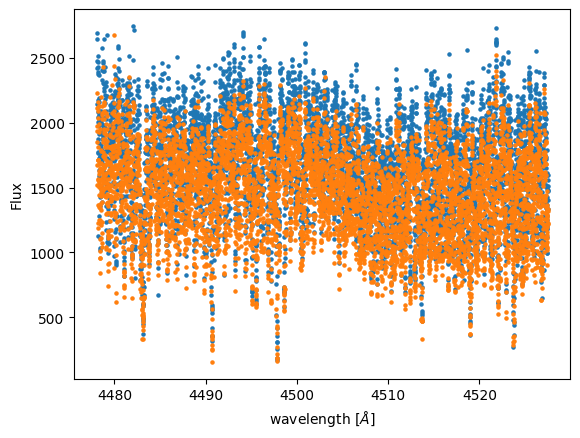

In [37]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots()
for frameID in data.get_valid_frameIDS():
    wave, flux, err, mask = data.get_frame_OBS_order(frameID=frameID,
                                                     order=50,
                                                     )

    good_pixel_mask = ~mask
    axis.scatter(wave[good_pixel_mask], flux[good_pixel_mask], s=5)
axis.set_xlabel(r"wavelength $[\AA]$")
axis.set_ylabel("Flux")
